In [1]:

import zlib
from typing import Dict, Any

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pywt
import scipy.fft
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from perlin_noise import PerlinNoise
from tensorly import tucker_to_tensor, unfold
from tensorly.decomposition import tucker

# Configure matplotlib for jupyter
%matplotlib inline
plt.rcParams['animation.embed_limit'] = 2 ** 128

In [2]:
# Data dimensions
CUBE_SIZE = 8
NUM_FRAMES = 128

# Simulation parameters for a moving Gaussian blob
BLOB_SIGMA = 3.0  # Controls the size of the blob

In [3]:
import numpy as np


def generate_time_series_data(frames, size, sigma, noise_level=0.0):
    """
    Generates a time series of 3D data representing a moving Gaussian blob with added noise.

    Args:
        frames (int): The number of time frames.
        size (int): The size of each dimension of the 3D cube.
        sigma (float): The standard deviation of the Gaussian blob.
        noise_level (float): The amplitude of the random noise to add. 0.0 means no noise.

    Returns:
        np.ndarray: A 4D numpy array of shape (frames, size, size, size).
    """
    data = np.zeros((frames, size, size, size), dtype=np.float32)
    noise = np.random.rand(size, size, size) * noise_level

    # Create a coordinate grid
    x = np.linspace(-size / 2, size / 2, size)
    y, z = x, x
    zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')

    for t in range(frames):
        # Calculate the center of the blob at time t (moves diagonally)
        center_x = -size / 2 + (size / frames) * t
        center_y = -size / 2 + (size / frames) * t
        center_z = -size / 2 + (size / frames) * t

        # Generate the clean Gaussian blob
        exponent = -((xx - center_x) ** 2 + (yy - center_y) ** 2 + (zz - center_z) ** 2) / (2 * sigma ** 2)
        clean_data = np.exp(exponent)

        # Generate and add noise
        data[t, :, :, :] = clean_data * noise

    return data


def generate_perlin_3d_time_series(frames=32, size=8, frequency=2, octaves=2):
    """
    Generates a time series of 3D Perlin noise.

    Args:
        frames (int): The number of time frames.
        size (int): The size of each dimension of the 3D cube.
        frequency (int): The frequency of the noise pattern. Higher values mean more detail.
        octaves (int): The number of noise layers to combine. More octaves add complexity.

    Returns:
        np.ndarray: A 4D numpy array of shape (frames, size, size, size) with values from 0 to 1.
    """
    print(f"Generating 4D Perlin noise (frames={frames}, size={size}, freq={frequency}, octaves={octaves})...")
    # A seed ensures the noise is repeatable. We can have one for each octave.
    noise_generators = [PerlinNoise(octaves=octaves, seed=s) for s in range(4)]

    data = np.zeros((frames, size, size, size), dtype=np.float32)

    # Generate the noise field
    for t in range(frames):
        for z in range(size):
            for y in range(size):
                for x in range(size):
                    # Sample noise at a 4D coordinate
                    # We scale the coordinates by frequency to control the "zoom" level of the noise
                    noise_val = noise_generators[0]([x / size * frequency,
                                                     y / size * frequency,
                                                     z / size * frequency,
                                                     t / frames * frequency * 4])
                    data[t, z, y, x] = noise_val

    # Normalize the data to be in the [0, 1] range
    data = (data - data.min()) / (data.max() - data.min())

    return data

In [4]:
import io
from typing import Tuple


def unfold(tensor, mode) -> np.ndarray:
    """Unfold tensor along specified mode for Tucker decomposition."""
    shape = list(tensor.shape)
    n = shape[mode]
    shape[mode] = 1
    return tensor.swapaxes(mode, 0).reshape(n, -1)


INT16_MAX = 32767


def quantize_to_int16(arr: np.ndarray) -> Tuple[np.ndarray, float]:
    """Symmetric uniform quantisation to int16; returns (q, scale)."""
    max_abs = float(np.max(np.abs(arr)))
    if max_abs < 1e-12:  # all‑zero tensor
        return np.zeros(arr.shape, dtype=np.int16), 0.0
    scale = max_abs / INT16_MAX
    q = np.round(arr / scale).astype(np.int16)
    return q, scale


def dequantize_from_int16(q: np.ndarray, scale: float) -> np.ndarray:
    if scale == 0.0:
        return np.zeros(q.shape, dtype=np.float32)
    return q.astype(np.float32) * scale


def _compute_tucker_ranks_by_energy(tensor, energy=0.9):
    """
    Compute minimal Tucker ranks per mode so that each unfolding preserves
    `energy` fraction of squared singular values.
    """
    ranks = []
    for mode in range(tensor.ndim):
        unfolding = unfold(tensor, mode)
        U, S, Vt = np.linalg.svd(unfolding, full_matrices=False)
        cumulative = np.cumsum(S ** 2)
        total = cumulative[-1]
        if total < 1e-12:  # Handle near-zero tensors
            ranks.append(1)
            continue
        rank = int(np.searchsorted(cumulative, energy * total) + 1)
        rank = min(rank, tensor.shape[mode])
        ranks.append(rank)
    return ranks


def compress_3d_spatial_1d_temporal(data_series,
                                    spatial_wavelet='db4',
                                    temporal_wavelet='db4',
                                    spatial_threshold=0.05,
                                    temporal_threshold=0.01,
                                    tucker_energy=0.9):
    """
    Compress 4D (x,y,z,t) data using separated 3D spatial + 1D temporal approach.

    Args:
        data_series: 4D numpy array (x, y, z, t)
        spatial_wavelet: Wavelet for 3D spatial transform
        temporal_wavelet: Wavelet for 1D temporal transform
        spatial_threshold: Threshold for spatial coefficients
        temporal_threshold: Threshold for temporal coefficients
        tucker_energy: Energy preservation for automatic rank selection

    Returns:
        dict: Compressed representation
    """
    print(f"Compressing {data_series.shape} using 3D spatial + 1D temporal pipeline")
    original_shape = data_series.shape
    x_dim, y_dim, z_dim, t_dim = original_shape

    payload = {
        'original_shape': original_shape,
        'spatial_wavelet': spatial_wavelet,
        'temporal_wavelet': temporal_wavelet,
        'spatial_threshold': spatial_threshold,
        'temporal_threshold': temporal_threshold,
        'dtype': str(data_series.dtype),
    }

    # Step 1: 3D Spatial DWT on each time frame
    print("Step 1: 3D spatial DWT on each frame...")
    spatial_coeffs_over_time = {}

    # Get coefficient structure from first frame
    first_frame_coeffs = pywt.dwtn(data_series[:, :, :, 0], spatial_wavelet)
    coeff_keys = list(first_frame_coeffs.keys())

    # Initialize storage for each coefficient type across time
    for key in coeff_keys:
        coeff_shape = first_frame_coeffs[key].shape
        spatial_coeffs_over_time[key] = np.zeros((*coeff_shape, t_dim))

    # Compute 3D spatial DWT for each frame
    for t in range(t_dim):
        frame_coeffs = pywt.dwtn(data_series[:, :, :, t], spatial_wavelet)
        for key in coeff_keys:
            spatial_coeffs_over_time[key][:, :, :, t] = frame_coeffs[key]

    # Step 2: Process each spatial coefficient type over time
    print("Step 2: Processing spatial coefficients over time...")
    compressed_blocks = {}
    total_stored_elements = 0  # Changed from floats to elements (could be int16)
    total_original_size = np.prod(original_shape)

    for key, coeff_4d in spatial_coeffs_over_time.items():
        print(f"\nProcessing coefficient block '{key}' with shape {coeff_4d.shape}")

        # Apply spatial thresholding
        spatial_mask = np.abs(coeff_4d) < spatial_threshold
        coeff_4d_thresh = coeff_4d.copy()
        coeff_4d_thresh[spatial_mask] = 0.0

        spatial_sparsity = np.count_nonzero(spatial_mask) / coeff_4d.size * 100
        print(f"  Spatial sparsity after thresholding: {spatial_sparsity:.1f}%")

        # Step 3: Temporal compression on remaining coefficients
        sx, sy, sz, st = coeff_4d_thresh.shape
        approx_coeffs, detail_coeffs = pywt.dwt(coeff_4d_thresh, temporal_wavelet, axis=-1, mode='periodization')

        # Apply temporal thresholding
        approx_coeffs[np.abs(approx_coeffs) < temporal_threshold] = 0.0
        detail_coeffs[np.abs(detail_coeffs) < temporal_threshold] = 0.0

        total_temporal_elements = approx_coeffs.size + detail_coeffs.size
        total_temporal_nonzeros = np.count_nonzero(approx_coeffs) + np.count_nonzero(detail_coeffs)
        temporal_sparsity = (1 - total_temporal_nonzeros / total_temporal_elements) * 100
        print(f"  Temporal sparsity after thresholding: {temporal_sparsity:.1f}%")

        # Step 4: Tucker decomposition on the processed block
        block_info = {
            'original_shape': coeff_4d.shape,
            'sparsity_percent': temporal_sparsity,
        }

        # Handle DWT case with separate approximation and detail coefficients
        stored_elements = 0

        # Process approximation coefficients
        approx_nonzeros = np.count_nonzero(approx_coeffs)

        if approx_nonzeros > 0:
            ranks_approx = _compute_tucker_ranks_by_energy(approx_coeffs, energy=tucker_energy)
            full_ranks_approx = list(approx_coeffs.shape)
            tucker_size_approx = np.prod(ranks_approx) + sum(
                ranks_approx[i] * approx_coeffs.shape[i] for i in range(len(ranks_approx)))

            if ranks_approx != full_ranks_approx and tucker_size_approx < approx_nonzeros:
                core_approx, factors_approx = tucker(approx_coeffs, rank=ranks_approx, init='svd')

                # Quantize core tensor
                q_core_approx, core_scale_approx = quantize_to_int16(core_approx)

                # Quantize factor matrices
                q_factors_approx = []
                factors_scales_approx = []
                for factor in factors_approx:
                    q_factor, factor_scale = quantize_to_int16(factor)
                    q_factors_approx.append(q_factor)
                    factors_scales_approx.append(factor_scale)

                block_info['approx'] = {
                    'type': 'tucker_quantized',
                    'q_core': q_core_approx,
                    'core_scale': core_scale_approx,
                    'q_factors': q_factors_approx,
                    'factors_scales': factors_scales_approx,
                    'ranks': ranks_approx
                }

                # Count stored elements (either float32 or int16 + scale)
                stored_elements += np.count_nonzero(q_core_approx) + sum(
                    np.count_nonzero(f) for f in q_factors_approx)
                # Add the scales (one per core and one per factor)
                stored_elements += 1 + len(factors_scales_approx)

            else:
                q_approx, approx_scale = quantize_to_int16(approx_coeffs)
                block_info['approx'] = {
                    'type': 'sparse_quantized',
                    'q_data': q_approx,
                    'scale': approx_scale
                }
                stored_elements += np.count_nonzero(q_approx) + 1  # +1 for scale

        else:
            q_approx, approx_scale = quantize_to_int16(approx_coeffs)
            block_info['approx'] = {
                'type': 'sparse_quantized',
                'q_data': q_approx,
                'scale': approx_scale
            }
            stored_elements += np.count_nonzero(q_approx) + 1  # +1 for scale

        # Process detail coefficients
        detail_nonzeros = np.count_nonzero(detail_coeffs)

        if detail_nonzeros > 0:
            ranks_detail = _compute_tucker_ranks_by_energy(detail_coeffs, energy=tucker_energy)
            full_ranks_detail = list(detail_coeffs.shape)
            tucker_size_detail = np.prod(ranks_detail) + sum(
                ranks_detail[i] * detail_coeffs.shape[i] for i in range(len(ranks_detail)))

            if ranks_detail != full_ranks_detail and tucker_size_detail < detail_nonzeros:
                core_detail, factors_detail = tucker(detail_coeffs, rank=ranks_detail, init='svd')

                # Quantize core tensor
                q_core_detail, core_scale_detail = quantize_to_int16(core_detail)

                # Quantize factor matrices
                q_factors_detail = []
                factors_scales_detail = []
                for factor in factors_detail:
                    q_factor, factor_scale = quantize_to_int16(factor)
                    q_factors_detail.append(q_factor)
                    factors_scales_detail.append(factor_scale)

                block_info['detail'] = {
                    'type': 'tucker_quantized',
                    'q_core': q_core_detail,
                    'core_scale': core_scale_detail,
                    'q_factors': q_factors_detail,
                    'factors_scales': factors_scales_detail,
                    'ranks': ranks_detail
                }

                # Count stored elements
                stored_elements += np.count_nonzero(q_core_detail) + sum(
                    np.count_nonzero(f) for f in q_factors_detail)
                # Add the scales (one per core and one per factor)
                stored_elements += 1 + len(factors_scales_detail)

            else:
                q_detail, detail_scale = quantize_to_int16(detail_coeffs)
                block_info['detail'] = {
                    'type': 'sparse_quantized',
                    'q_data': q_detail,
                    'scale': detail_scale
                }
                stored_elements += np.count_nonzero(q_detail) + 1  # +1 for scale
        else:
            q_detail, detail_scale = quantize_to_int16(detail_coeffs)
            block_info['detail'] = {
                'type': 'sparse_quantized',
                'q_data': q_detail,
                'scale': detail_scale
            }
            stored_elements += np.count_nonzero(q_detail) + 1  # +1 for scale

        stored = stored_elements
        print(f"DWT: approx nonzeros {approx_nonzeros}, detail nonzeros {detail_nonzeros}, total stored: {stored}")

        block_info['stored_elements'] = stored
        compressed_blocks[key] = block_info
        total_stored_elements += stored

    # Final statistics
    # For compression ratio, count the bits actually used
    # Each int16 is 2 bytes, each scale is 4 bytes (float32)
    total_stored_bytes = (total_stored_elements * 2)  # Approximate, not counting scales separately
    original_bytes = total_original_size * 4  # float32
    compression_ratio = original_bytes / total_stored_bytes if total_stored_bytes > 0 else np.inf

    overall_sparsity = (1 - total_stored_elements / total_original_size) * 100

    print(f"\n=== Compression Summary ===")
    print(f"Original size: {total_original_size} elements")
    print(f"Stored elements: {total_stored_elements}")
    print(f"Overall sparsity: {overall_sparsity:.1f}%")
    print(f"Compression ratio: {compression_ratio:.1f}:1")

    payload.update({
        'compressed_blocks': compressed_blocks,
        'compression_stats': {
            'total_stored_elements': total_stored_elements,
            'compression_ratio': compression_ratio,
            'overall_sparsity': overall_sparsity
        }
    })

    return payload


def decompress_3d_spatial_1d_temporal(compressed_data):
    """
    Decompress data compressed with compress_3d_spatial_1d_temporal.
    """
    print("Decompressing 3D spatial + 1D temporal data...")

    original_shape = compressed_data['original_shape']
    spatial_wavelet = compressed_data['spatial_wavelet']
    temporal_wavelet = compressed_data['temporal_wavelet']
    blocks = compressed_data['compressed_blocks']

    spatial_coeffs_over_time = {}

    for key, block_info in blocks.items():
        print(f"Reconstructing block '{key}'...")

        # --- FIXED LOGIC: Directly process 'approx' and 'detail' components ---
        # as the compression function always creates them.

        # --- Reconstruct approximation coefficients ---
        approx_info = block_info['approx']
        approx_type = approx_info['type']

        if not approx_info['q_data'].size == 0 if 'q_data' in approx_info else True:
            if approx_type == 'tucker_quantized':
                core = dequantize_from_int16(approx_info['q_core'], approx_info['core_scale'])
                factors = [dequantize_from_int16(qf, s) for qf, s in
                           zip(approx_info['q_factors'], approx_info['factors_scales'])]
                approx_coeffs = tucker_to_tensor((core, factors))
            elif approx_type == 'sparse_quantized':
                approx_coeffs = dequantize_from_int16(approx_info['q_data'], approx_info['scale'])
        else:  # Handle all-zero case
            # Infer shape from original block shape and DWT properties
            approx_shape = list(block_info['original_shape'])
            approx_shape[3] = (approx_shape[3] + pywt.Wavelet(temporal_wavelet).dec_len - 1) // 2
            approx_coeffs = np.zeros(approx_shape)

        # --- Reconstruct detail coefficients ---
        detail_info = block_info['detail']
        detail_type = detail_info['type']

        if not detail_info['q_data'].size == 0 if 'q_data' in detail_info else True:
            if detail_type == 'tucker_quantized':
                core = dequantize_from_int16(detail_info['q_core'], detail_info['core_scale'])
                factors = [dequantize_from_int16(qf, s) for qf, s in
                           zip(detail_info['q_factors'], detail_info['factors_scales'])]
                detail_coeffs = tucker_to_tensor((core, factors))
            elif detail_type == 'sparse_quantized':
                detail_coeffs = dequantize_from_int16(detail_info['q_data'], detail_info['scale'])
        else:  # Handle all-zero case
            detail_shape = list(block_info['original_shape'])
            detail_shape[3] = (detail_shape[3] + pywt.Wavelet(temporal_wavelet).dec_len - 1) // 2
            detail_coeffs = np.zeros(detail_shape)

        # --- Reconstruct temporal signals using inverse DWT ---
        reconstructed = pywt.idwt(approx_coeffs, detail_coeffs, temporal_wavelet, axis=-1, mode='periodization')

        # Ensure final shape matches original coefficient block shape before spatial transform
        original_block_shape = block_info['original_shape']
        if reconstructed.shape != original_block_shape:
            reconstructed = reconstructed[..., :original_block_shape[-1]]

        spatial_coeffs_over_time[key] = reconstructed

    # Reconstruct each time frame using inverse 3D spatial DWT
    print("\nStep 2: Reconstructing frames with inverse 3D spatial DWT...")
    reconstructed_series = np.zeros(original_shape, dtype=np.float32)
    x_dim, y_dim, z_dim, t_dim = original_shape

    for t in range(t_dim):
        # Extract coefficients for this time frame
        frame_coeffs = {key: tensor[..., t] for key, tensor in spatial_coeffs_over_time.items()}

        # Inverse 3D DWT
        frame_reconstructed = pywt.idwtn(frame_coeffs, spatial_wavelet, axes=(0, 1, 2))

        # Handle potential size mismatches from wavelet transform
        reconstructed_series[:frame_reconstructed.shape[0], :frame_reconstructed.shape[1],
        :frame_reconstructed.shape[2], t] = frame_reconstructed

    print("Decompression complete.")
    return reconstructed_series


def compress_dct_3d_1d_zlib(
        data_series: np.ndarray,
        block_size: int = 8,
        dct_threshold: float = 0.01
) -> Dict[str, Any]:
    """
    Compresses a 4D tensor using block-based DCT and zlib for lossless encoding.
    """
    # Steps 1-4 are identical to your original DCT compression function...
    print(f"Compressing {data_series.shape} with DCT + ZLIB")
    original_shape = data_series.shape
    x_dim, y_dim, z_dim, t_dim = original_shape
    bs = block_size

    pad_x = (bs - x_dim % bs) % bs
    pad_y = (bs - y_dim % bs) % bs
    pad_z = (bs - z_dim % bs) % bs
    pad_width = ((0, pad_x), (0, pad_y), (0, pad_z), (0, 0))
    padded_data = np.pad(data_series, pad_width, mode='constant', constant_values=0)
    padded_shape = padded_data.shape

    spatial_dct_coeffs = np.zeros(padded_shape, dtype=np.float32)
    for t in range(t_dim):
        for i in range(0, padded_shape[0], bs):
            for j in range(0, padded_shape[1], bs):
                for k in range(0, padded_shape[2], bs):
                    block = padded_data[i:i + bs, j:j + bs, k:k + bs, t]
                    spatial_dct_coeffs[i:i + bs, j:j + bs, k:k + bs, t] = scipy.fft.dctn(block, type=2, norm='ortho')

    final_coeffs = scipy.fft.dct(spatial_dct_coeffs, type=2, norm='ortho', axis=3)
    final_coeffs[np.abs(final_coeffs) < dct_threshold] = 0.0

    # --- Step 5: Quantize ---
    q_coeffs, scale = quantize_to_int16(final_coeffs)

    # --- Step 6: Create sparse representation and losslessly compress with zlib ---
    print("Step 6: Creating sparse representation and compressing with zlib...")
    indices = np.nonzero(q_coeffs)
    values = q_coeffs[indices]

    # Pack data for compression
    # We use uint32 for indices to save space over the default int64
    packed_data = {
        'indices': np.vstack(indices).astype(np.uint32),
        'values': values
    }

    buffer = io.BytesIO()
    np.savez_compressed(buffer, **packed_data)
    buffer.seek(0)
    compressed_blob = zlib.compress(buffer.read(), level=9)

    # --- Finalize Payload ---
    original_bytes = data_series.nbytes
    stored_bytes = len(compressed_blob) + np.dtype(np.float32).itemsize  # blob + scale
    compression_ratio = original_bytes / stored_bytes if stored_bytes > 0 else float('inf')

    print("\n=== Compression Summary ===")
    print(f"Stored non-zero elements: {len(values)}")
    print(f"Original size: {original_bytes / 1e6:.2f} MB")
    print(f"Compressed size (ZLIB): {stored_bytes / 1e6:.2f} MB")
    print(f"Compression ratio: {compression_ratio:.1f}:1")

    payload = {
        'compressor': 'dct_3d_1d_zlib',
        'original_shape': original_shape,
        'padded_shape': padded_shape,
        'block_size': block_size,
        'scale': scale,
        'compressed_blob': compressed_blob,
    }
    return payload


def decompress_dct_3d_1d_zlib(payload: Dict[str, Any]) -> np.ndarray:
    """ Decompresses data compressed by the zlib-enabled function. """
    print("Decompressing block DCT (3D spatial + 1D temporal) with ZLIB...")

    # --- Step 1: Extract data from payload ---
    original_shape = payload['original_shape']
    padded_shape = payload['padded_shape']
    block_size = payload['block_size']
    scale = payload['scale']
    compressed_blob = payload['compressed_blob']
    bs = block_size
    t_dim = original_shape[3]

    # --- Step 2: Decompress with zlib and reconstruct sparse data ---
    print("Step 2: Decompressing blob with zlib and reconstructing sparse tensor...")
    import io
    decompressed_bytes = zlib.decompress(compressed_blob)
    unpacked_data = np.load(io.BytesIO(decompressed_bytes))
    indices_arr = unpacked_data['indices']
    values = unpacked_data['values']

    # Convert N x 4 array back to tuple of arrays for numpy indexing
    indices = tuple(indices_arr[i] for i in range(indices_arr.shape[0]))

    q_coeffs = np.zeros(padded_shape, dtype=np.int16)
    q_coeffs[indices] = values

    # --- The rest of the decompression is identical ---
    print("Step 3: Dequantizing...")
    final_coeffs = dequantize_from_int16(q_coeffs, scale)

    print("Step 4: Applying 1D inverse DCT...")
    spatial_dct_coeffs = scipy.fft.idct(final_coeffs, type=2, norm='ortho', axis=3)

    print("Step 5: Applying 3D inverse DCT to blocks...")
    padded_reconstructed = np.zeros(padded_shape, dtype=np.float32)
    for t in range(t_dim):
        for i in range(0, padded_shape[0], bs):
            for j in range(0, padded_shape[1], bs):
                for k in range(0, padded_shape[2], bs):
                    dct_block = spatial_dct_coeffs[i:i + bs, j:j + bs, k:k + bs, t]
                    reconstructed_block = scipy.fft.idctn(dct_block, type=2, norm='ortho')
                    padded_reconstructed[i:i + bs, j:j + bs, k:k + bs, t] = reconstructed_block

    print("Step 6: Removing padding...")
    reconstructed_series = padded_reconstructed[:original_shape[0], :original_shape[1], :original_shape[2],
                           :original_shape[3]]

    print("Decompression complete.")
    return reconstructed_series


def compress_dct_dwt_hybrid(
        data_series: np.ndarray,
        block_size: int = 8,
        temporal_wavelet: str = 'db4',
        approx_threshold: float = 0.1,
        detail_threshold: float = 0.5
) -> Dict[str, Any]:
    """
    Compresses a 4D tensor using 3D spatial DCT and 1D temporal DWT.
    """
    print(f"Compressing {data_series.shape} with Hybrid DCT-DWT...")
    original_shape = data_series.shape
    x_dim, y_dim, z_dim, t_dim = original_shape
    bs = block_size

    # --- Step 1: Padding & Blocking ---
    pad_x = (bs - x_dim % bs) % bs
    pad_y = (bs - y_dim % bs) % bs
    pad_z = (bs - z_dim % bs) % bs
    pad_width = ((0, pad_x), (0, pad_y), (0, pad_z), (0, 0))
    padded_data = np.pad(data_series, pad_width, mode='constant', constant_values=0)
    padded_shape = padded_data.shape

    # --- Step 2: 3D Spatial DCT ---
    print("Step 2: Applying 3D DCT to spatial blocks...")
    spatial_dct_coeffs = np.zeros(padded_shape, dtype=np.float32)
    for t in range(t_dim):
        for i in range(0, padded_shape[0], bs):
            for j in range(0, padded_shape[1], bs):
                for k in range(0, padded_shape[2], bs):
                    block = padded_data[i:i + bs, j:j + bs, k:k + bs, t]
                    spatial_dct_coeffs[i:i + bs, j:j + bs, k:k + bs, t] = scipy.fft.dctn(block, type=2, norm='ortho')

    # --- Step 3: 1D Temporal DWT ---
    print(f"Step 3: Applying 1D DWT ('{temporal_wavelet}') along temporal axis...")
    # This transforms across time for each coefficient position (i,j,k)
    approx_coeffs, detail_coeffs = pywt.dwt(spatial_dct_coeffs, temporal_wavelet, axis=3)

    # --- Step 4: Thresholding & Quantization (Separately for Approx/Detail) ---
    print(f"Step 4: Thresholding (approx={approx_threshold}, detail={detail_threshold}) and Quantizing...")
    approx_coeffs[np.abs(approx_coeffs) < approx_threshold] = 0.0
    detail_coeffs[np.abs(detail_coeffs) < detail_threshold] = 0.0

    q_approx, scale_approx = quantize_to_int16(approx_coeffs)
    q_detail, scale_detail = quantize_to_int16(detail_coeffs)

    # --- Step 5: Create sparse representation and losslessly compress with zlib ---
    print("Step 5: Creating sparse representation and compressing with zlib...")
    approx_indices = np.nonzero(q_approx)
    approx_values = q_approx[approx_indices]

    detail_indices = np.nonzero(q_detail)
    detail_values = q_detail[detail_indices]

    packed_data = {
        'approx_indices': np.vstack(approx_indices).astype(np.uint32),
        'approx_values': approx_values,
        'detail_indices': np.vstack(detail_indices).astype(np.uint32),
        'detail_values': detail_values,
    }

    buffer = io.BytesIO()
    np.savez_compressed(buffer, **packed_data)
    buffer.seek(0)
    compressed_blob = zlib.compress(buffer.read(), level=9)

    # --- Finalize Payload ---
    original_bytes = data_series.nbytes
    # blob + 2 scales
    stored_bytes = len(compressed_blob) + 2 * np.dtype(np.float32).itemsize
    compression_ratio = original_bytes / stored_bytes if stored_bytes > 0 else float('inf')

    print("\n=== Hybrid Compression Summary ===")
    print(f"Stored non-zero elements: Approx={len(approx_values)}, Detail={len(detail_values)}")
    print(f"Original size: {original_bytes / 1e6:.2f} MB")
    print(f"Compressed size (ZLIB): {stored_bytes / 1e6:.2f} MB")
    print(f"Compression ratio: {compression_ratio:.1f}:1")

    payload = {
        'compressor': 'dct_dwt_hybrid',
        'original_shape': original_shape,
        'padded_shape': padded_shape,
        'approx_shape': approx_coeffs.shape,
        'detail_shape': detail_coeffs.shape,
        'temporal_wavelet': temporal_wavelet,
        'scale_approx': scale_approx,
        'scale_detail': scale_detail,
        'compressed_blob': compressed_blob,
    }
    return payload


def decompress_dct_dwt_hybrid(payload: Dict[str, Any]) -> np.ndarray:
    """ Decompresses data compressed by the hybrid DCT-DWT function. """
    print("Decompressing hybrid DCT-DWT data...")

    # --- Step 1: Extract data from payload ---
    original_shape = payload['original_shape']
    padded_shape = payload['padded_shape']
    approx_shape = payload['approx_shape']
    detail_shape = payload['detail_shape']
    temporal_wavelet = payload['temporal_wavelet']
    scale_approx = payload['scale_approx']
    scale_detail = payload['scale_detail']
    compressed_blob = payload['compressed_blob']

    # --- Step 2: Decompress with zlib and reconstruct sparse data ---
    print("Step 2: Decompressing blob and reconstructing sparse tensors...")
    decompressed_bytes = zlib.decompress(compressed_blob)
    unpacked_data = np.load(io.BytesIO(decompressed_bytes))

    # Reconstruct Approx
    approx_indices_arr = unpacked_data['approx_indices']
    approx_indices = tuple(approx_indices_arr[i] for i in range(approx_indices_arr.shape[0]))
    q_approx = np.zeros(approx_shape, dtype=np.int16)
    q_approx[approx_indices] = unpacked_data['approx_values']

    # Reconstruct Detail
    detail_indices_arr = unpacked_data['detail_indices']
    detail_indices = tuple(detail_indices_arr[i] for i in range(detail_indices_arr.shape[0]))
    q_detail = np.zeros(detail_shape, dtype=np.int16)
    q_detail[detail_indices] = unpacked_data['detail_values']

    # --- Step 3: Dequantize ---
    print("Step 3: Dequantizing approx and detail coefficients...")
    approx_coeffs = dequantize_from_int16(q_approx, scale_approx)
    detail_coeffs = dequantize_from_int16(q_detail, scale_detail)

    # --- Step 4: 1D Inverse Temporal DWT ---
    print(f"Step 4: Applying 1D inverse DWT ('{temporal_wavelet}')...")
    spatial_dct_coeffs = pywt.idwt(approx_coeffs, detail_coeffs, temporal_wavelet, axis=3)

    # Trim if idwt produces an extra sample
    spatial_dct_coeffs = spatial_dct_coeffs[:, :, :, :padded_shape[3]]

    # --- Step 5: 3D Inverse Spatial DCT ---
    print("Step 5: Applying 3D inverse DCT to spatial blocks...")
    padded_reconstructed = np.zeros(padded_shape, dtype=np.float32)
    for t in range(padded_shape[3]):
        for i in range(0, padded_shape[0], 8):
            for j in range(0, padded_shape[1], 8):
                for k in range(0, padded_shape[2], 8):
                    dct_block = spatial_dct_coeffs[i:i + 8, j:j + 8, k:k + 8, t]
                    reconstructed_block = scipy.fft.idctn(dct_block, type=2, norm='ortho')
                    padded_reconstructed[i:i + 8, j:j + 8, k:k + 8, t] = reconstructed_block

    # --- Step 6: Remove padding ---
    print("Step 6: Removing padding...")
    reconstructed_series = padded_reconstructed[
                           :original_shape[0], :original_shape[1], :original_shape[2], :original_shape[3]
                           ]

    print("Decompression complete.")
    return reconstructed_series

In [5]:
# 1. Generate the original data
#original_data = generate_time_series_data(NUM_FRAMES, CUBE_SIZE, BLOB_SIGMA, noise_level=1)
original_data = generate_perlin_3d_time_series(frames=NUM_FRAMES, size=CUBE_SIZE, frequency=1, octaves=2)


Generating 4D Perlin noise (frames=128, size=8, freq=1, octaves=2)...


In [30]:

# 2. Pass data through the compression/decompression pipeline
#compressed_output = compress_3d_spatial_1d_temporal(original_data, spatial_threshold=0.05, temporal_threshold=0.2, tucker_energy = 0.99)

#decompressed_data = decompress_3d_spatial_1d_temporal(compressed_output)

compressed_output = compress_dct_3d_1d_zlib(original_data, block_size=CUBE_SIZE, dct_threshold=0.2)

decompressed_data = decompress_dct_3d_1d_zlib(compressed_output)

# 4. Check for data integrity (optional sanity check)
print(f"\nData shapes match: {original_data.shape == decompressed_data.shape}")

# Calculate and print the Mean Squared Error to quantify the error
mse = np.mean((original_data - decompressed_data) ** 2)
print(f"Mean Squared Error: {mse:.8f}")

Compressing (128, 8, 8, 8) with DCT + ZLIB
Step 6: Creating sparse representation and compressing with zlib...

=== Compression Summary ===
Stored non-zero elements: 1700
Original size: 0.26 MB
Compressed size (ZLIB): 0.00 MB
Compression ratio: 53.6:1
Decompressing block DCT (3D spatial + 1D temporal) with ZLIB...
Step 2: Decompressing blob with zlib and reconstructing sparse tensor...
Step 3: Dequantizing...
Step 4: Applying 1D inverse DCT...
Step 5: Applying 3D inverse DCT to blocks...
Step 6: Removing padding...
Decompression complete.

Data shapes match: True
Mean Squared Error: 0.00053842


In [31]:
def visualize_slice_comparison(original, decompressed, slice_axis_idx=0, slice_pos=None):
    """
    Creates and displays an animation comparing a slice from the original and
    decompressed data series over time.

    Args:
        original (np.ndarray): The original 4D data series.
        decompressed (np.ndarray): The decompressed 4D data series.
        slice_axis_idx (int): The axis to slice (0=z, 1=y, 2=x).
        slice_pos (int): The position along the axis to take the slice. Defaults to center.
    """
    if slice_pos is None:
        slice_pos = original.shape[1] // 2

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    # Determine slicing
    slicing = [slice(None)] * 4
    slicing[slice_axis_idx + 1] = slice_pos  # +1 to skip time axis
    slicing = tuple(slicing)

    # Initial plot setup
    vmin = min(original.min(), decompressed.min())
    vmax = max(original.max(), decompressed.max())

    im1 = ax1.imshow(original[slicing][0], cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title("Original Data")

    im2 = ax2.imshow(decompressed[slicing][0], cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title("Decompressed Data")

    im3 = ax3.imshow((original[slicing][0] - decompressed[slicing][0]) ** 2, cmap='magma', vmin=vmin, vmax=vmax)
    ax3.set_title("Difference (Original - Decompressed)")

    fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', fraction=0.046, pad=0.1)
    fig.colorbar(im3, ax=[ax3], orientation='vertical', fraction=0.046, pad=0.1)

    def update(frame):
        # Update the data for each image
        im1.set_data(original[slicing][frame])
        im2.set_data(decompressed[slicing][frame])
        im3.set_data(original[slicing][frame] - decompressed[slicing][frame])

        # Update the title to show the current time frame
        fig.suptitle(f'Frame: {frame}/{original.shape[0] - 1}', fontsize=16)
        return [im1, im2]

    # Create and display the animation
    ani = FuncAnimation(fig, update, frames=original.shape[0], blit=True, interval=100)
    plt.close()  # Prevents static figure from displaying
    return HTML(ani.to_jshtml())


# Let's visualize a slice through the middle of the Z-axis (axis index 0)
# To view a slice along the X-axis, you would use slice_axis_idx=2
visualize_slice_comparison(original_data, decompressed_data, slice_axis_idx=0, slice_pos=CUBE_SIZE // 2)

C:\Users\zphrfx\AppData\Local\Temp\ipykernel_14712\3585509076.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


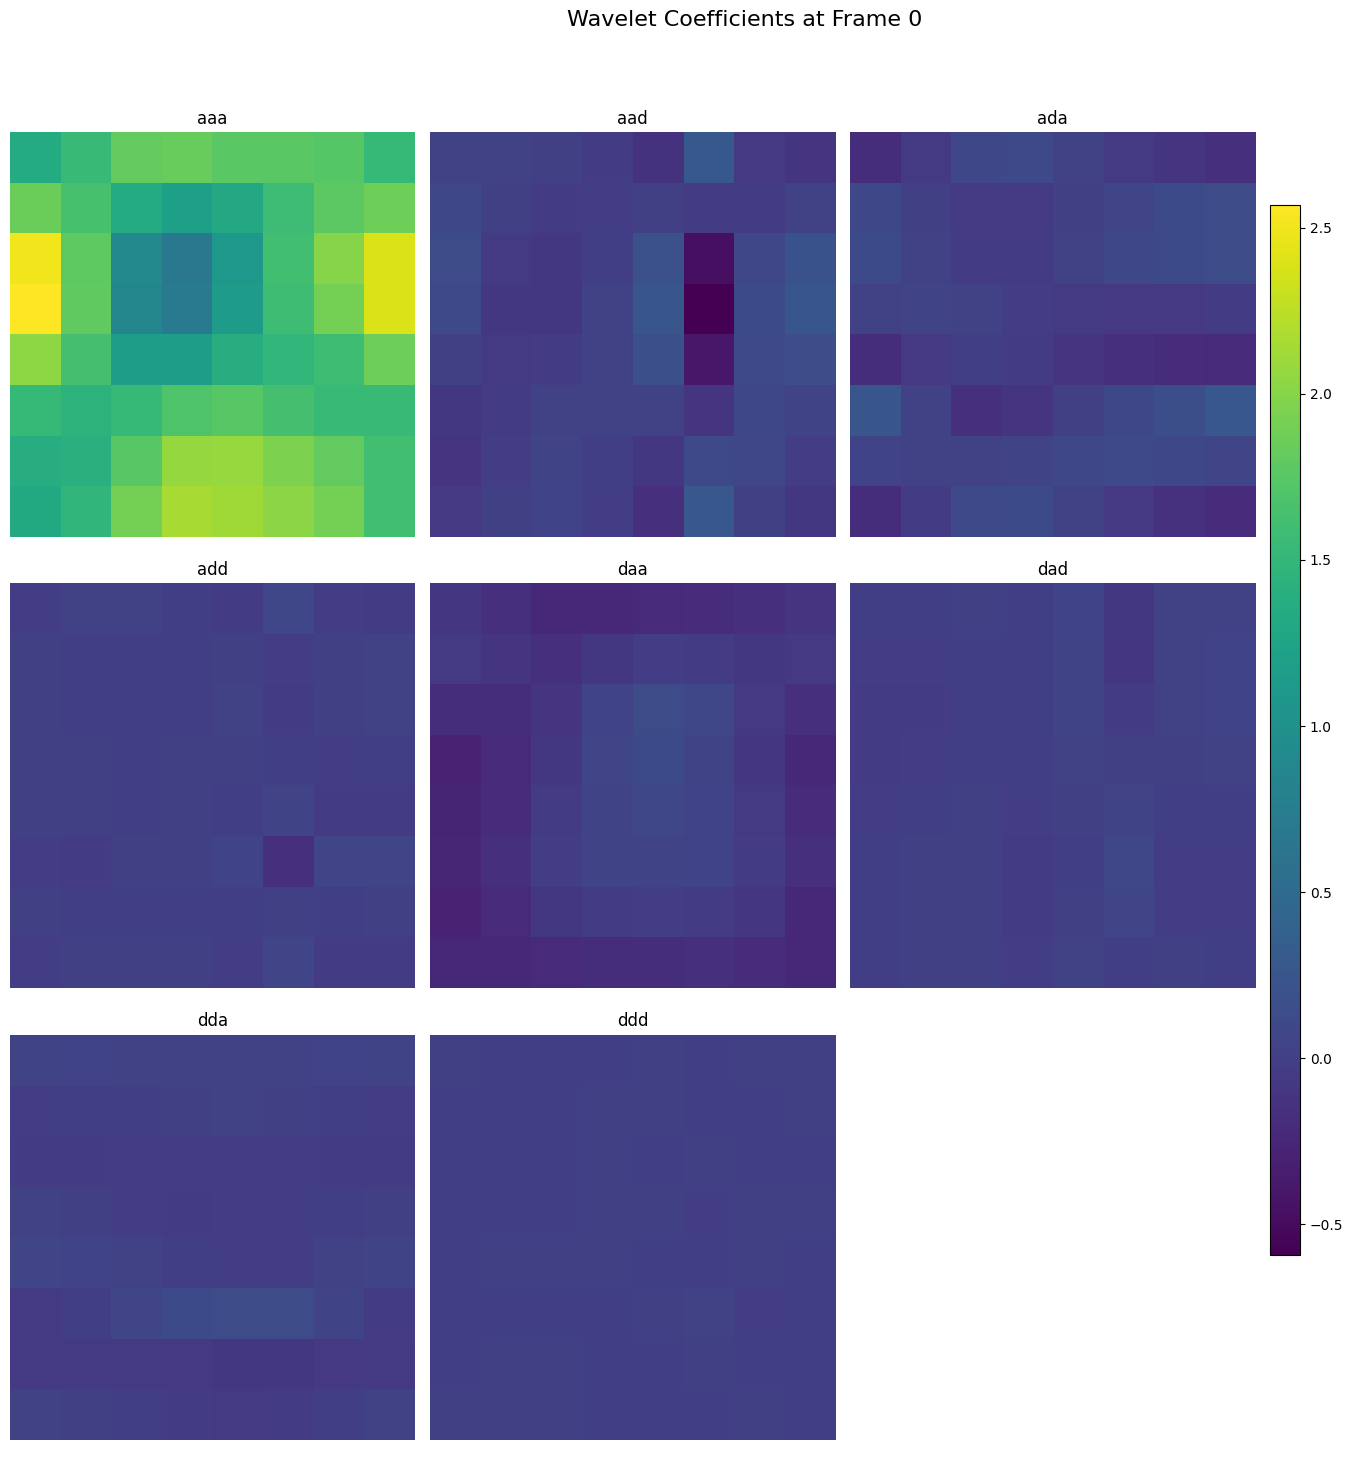

In [20]:
def extract_wavelet_coefficients(data, wavelet='db4', level=1):
    """
    Extract wavelet coefficients from 3D spatial data.

    Args:
        data: 3D numpy array (x, y, z)
        wavelet: wavelet to use
        level: decomposition level

    Returns:
        Dictionary of wavelet coefficients
    """
    return pywt.swtn(data, wavelet, level=level)[0]


def visualize_wavelet_coefficients(data_series, time_frame=0, wavelet='db4',
                                   slice_axis_idx=0, slice_pos=None):
    """
    Visualize different wavelet coefficient components for a single time frame.

    Args:
        data_series: 4D numpy array (t, x, y, z)
        time_frame: Time frame to visualize
        wavelet: Wavelet for decomposition
        slice_axis_idx: Axis to slice (0=z, 1=y, 2=x)
        slice_pos: Position along the axis to take the slice
    """
    if slice_pos is None:
        slice_pos = data_series.shape[slice_axis_idx + 1] // 2

    # Extract the time frame
    frame_data = data_series[time_frame]

    # Extract wavelet coefficients
    coeffs = extract_wavelet_coefficients(frame_data, wavelet)

    # Get all coefficient keys
    coeff_keys = list(coeffs.keys())

    # Create widgets for interactive selection
    coeff_dropdown = widgets.Dropdown(options=coeff_keys, description='Coefficient:')
    time_slider = widgets.IntSlider(
        min=0, max=data_series.shape[0] - 1, value=time_frame,
        description='Time Frame:', continuous_update=False
    )

    # Create visualization function
    def update_visualization(coeff_key, time_idx):
        # Get new time frame
        frame_data = data_series[time_idx]
        # Extract coefficients
        coeffs = extract_wavelet_coefficients(frame_data, wavelet)

        # Prepare the slicing
        slicing = [slice(None)] * 3
        slicing[slice_axis_idx] = slice_pos
        slicing = tuple(slicing)

        # Setup the figure
        fig, ax = plt.subplots(figsize=(10, 8))

        # Get coefficient data
        coeff_data = coeffs[coeff_key][slicing]

        # Display the coefficient
        im = ax.imshow(coeff_data, cmap='viridis')
        ax.set_title(f'Wavelet Coefficient: {coeff_key}, Frame: {time_idx}')
        fig.colorbar(im, ax=ax)
        plt.show()

    # Connect widgets to visualization function
    widgets.interactive(update_visualization, coeff_key=coeff_dropdown, time_idx=time_slider)


def visualize_coefficient_animation(data_series, coeff_key='aaa', wavelet='db4',
                                    slice_axis_idx=0, slice_pos=None):
    """
    Create an animation showing a specific wavelet coefficient over time.

    Args:
        data_series: 4D numpy array (t, x, y, z)
        coeff_key: Coefficient type to visualize (e.g., 'aaa', 'aad')
        wavelet: Wavelet for decomposition
        slice_axis_idx: Axis to slice (0=z, 1=y, 2=x)
        slice_pos: Position along the axis to take the slice
    """
    if slice_pos is None:
        slice_pos = CUBE_SIZE // 2

    # Extract coefficients for the first frame to get dimensions
    first_frame_coeffs = extract_wavelet_coefficients(data_series[0], wavelet)

    # Prepare the slicing
    slicing = [slice(None)] * 3
    slicing[slice_axis_idx] = slice_pos
    slicing = tuple(slicing)

    # Get dimensions for the selected coefficient type
    sample_coeff = first_frame_coeffs[coeff_key][slicing]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Initial plot
    im = ax.imshow(sample_coeff, cmap='viridis')
    title = ax.set_title(f'Wavelet Coefficient: {coeff_key}, Frame: 0')
    fig.colorbar(im, ax=ax)

    # Animation update function
    def update(frame):
        # Extract coefficients for the current frame
        frame_coeffs = extract_wavelet_coefficients(data_series[frame], wavelet)
        coeff_data = frame_coeffs[coeff_key][slicing]

        # Update the image data and title
        im.set_array(coeff_data)
        title.set_text(f'Wavelet Coefficient: {coeff_key}, Frame: {frame}')
        return [im, title]

    # Create animation
    ani = FuncAnimation(fig, update, frames=data_series.shape[0], blit=True, interval=100)
    plt.close()
    return HTML(ani.to_jshtml())


def compare_all_coefficients(data_series, time_frame=0, wavelet='db4', slice_axis_idx=0, slice_pos=None):
    """
    Create a grid visualization of all wavelet coefficients for a single time frame.

    Args:
        data_series: 4D numpy array (t, x, y, z)
        time_frame: Time frame to visualize
        wavelet: Wavelet for decomposition
        slice_axis_idx: Axis to slice (0=z, 1=y, 2=x)
        slice_pos: Position along the axis to take the slice
    """
    if slice_pos is None:
        slice_pos = data_series.shape[slice_axis_idx + 1] // 2

    # Extract the time frame
    frame_data = data_series[time_frame]

    # Extract wavelet coefficients
    coeffs = extract_wavelet_coefficients(frame_data, wavelet)

    # Get all coefficient keys
    coeff_keys = list(coeffs.keys())

    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(len(coeff_keys))))

    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    # Prepare the slicing
    slicing = [slice(None)] * 3
    slicing[slice_axis_idx] = slice_pos
    slicing = tuple(slicing)

    # Find global min and max for consistent colormap scaling
    vmin = min(coeffs[key][slicing].min() for key in coeff_keys)
    vmax = max(coeffs[key][slicing].max() for key in coeff_keys)

    # Plot each coefficient
    for i, key in enumerate(coeff_keys):
        coeff_data = coeffs[key][slicing]
        im = axes[i].imshow(coeff_data, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'{key}')
        axes[i].axis('off')

    # Hide unused axes
    for i in range(len(coeff_keys), len(axes)):
        axes[i].axis('off')

    # Add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.suptitle(f'Wavelet Coefficients at Frame {time_frame}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


# Example usage:
# 1. Interactive single coefficient visualization:
# visualize_wavelet_coefficients(data_series, time_frame=0, wavelet='db4', slice_axis_idx=0)

# 2. Animation of a specific coefficient over time:
#visualize_coefficient_animation(original_data, coeff_key='aaa', wavelet='db4', slice_axis_idx=0)

# 3. Grid visualization of all coefficients:
compare_all_coefficients(original_data, time_frame=0, wavelet='db4', slice_axis_idx=0)

Displaying all frames of the decompressed data slice:


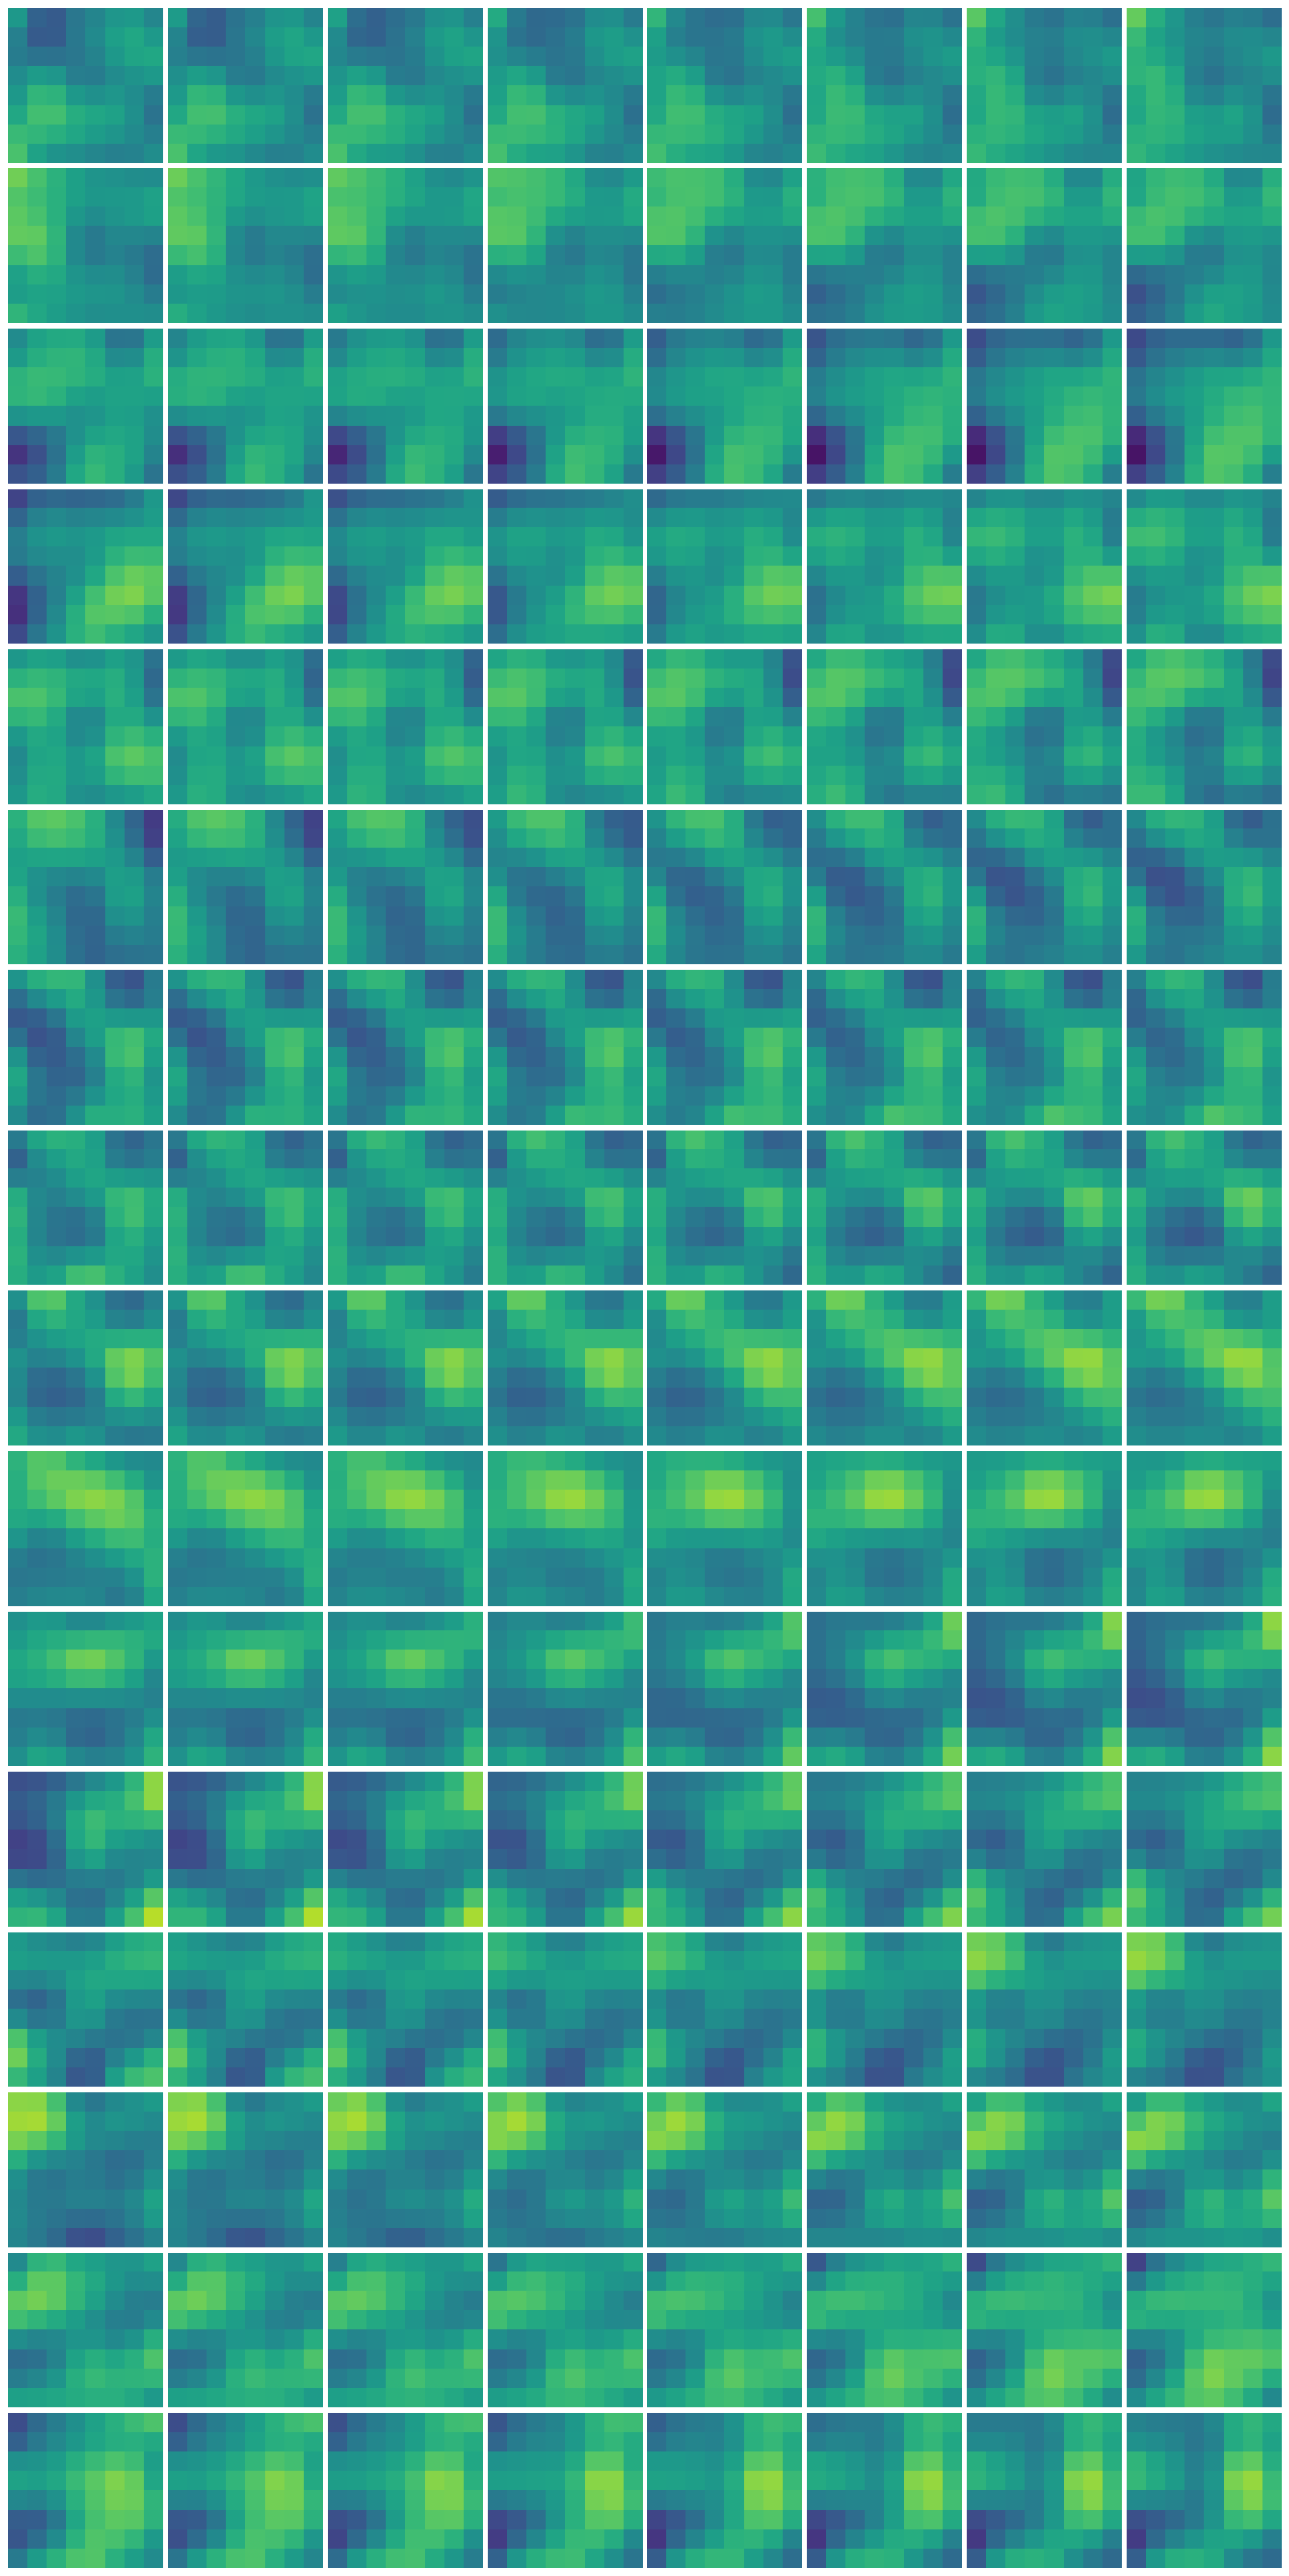

In [21]:
def visualize_all_frames_as_grid(data_series, slice_axis_idx=0, slice_pos=None):
    """
    Visualizes a slice from each frame of the data series in a grid.

    Args:
        data_series (np.ndarray): The 4D data series (time, z, y, x).
        slice_axis_idx (int): The axis to slice (0=z, 1=y, 2=x).
        slice_pos (int): Position along the axis for the slice. Defaults to center.
    """
    if slice_pos is None:
        slice_pos = data_series.shape[1] // 2

    num_frames = data_series.shape[0]

    # Determine grid size (e.g., 4 rows, 8 columns for 32 frames)
    grid_cols = 8
    grid_rows = (num_frames + grid_cols - 1) // grid_cols

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(16, grid_rows * 2))
    axes = axes.flatten()  # Flatten to make it easier to iterate

    # Determine slicing
    slicing = [slice(None)] * 3
    slicing[slice_axis_idx] = slice_pos
    slicing = tuple(slicing)

    # Global min/max for consistent color scaling
    vmin = data_series.min()
    vmax = data_series.max()

    for i in range(num_frames):
        ax = axes[i]
        # Extract the slice for the current frame
        frame_slice = data_series[i][slicing]

        ax.imshow(frame_slice, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.axis('off')  # Hide axes for a cleaner look

    # Hide any unused subplots
    for i in range(num_frames, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()


# Visualize the grid for the decompressed data
# This uses the same Z-slice as the animation for consistency
print("Displaying all frames of the decompressed data slice:")
visualize_all_frames_as_grid(decompressed_data, slice_axis_idx=0, slice_pos=CUBE_SIZE // 2)